In [3]:
import os
base_path = '/content/drive/MyDrive/Cv seed dataset'
for root, dirs, files in os.walk(base_path):
    print(root)
    break  # Just print top-level folder once

/content/drive/MyDrive/Cv seed dataset


In [4]:
# Import necessary libraries
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from PIL import Image
import torch.nn as nn
import torch
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Check CUDA availability
print(torch.version.cuda)  # Should NOT be None
print(torch.backends.cudnn.is_available())  # Should be True
print(torch.cuda.is_available())  # Should be True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

12.4
True
True
Using device: cuda


In [5]:
# Custom image loader that handles broken images
def image_loader(path):
    try:
        with open(path, 'rb') as f:
            img = Image.open(f).convert('RGB')
            return img
    except (IOError, OSError) as e:
        print(f"Error loading image {path}: {e}, skipping this image")
        return None

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(base_path, transform=val_test_transform, loader=image_loader)

# Remove corrupted images
dataset.samples = [s for s in dataset.samples if image_loader(s[0]) is not None]

# Split dataset into train, validation, and test sets (60%, 20%, 20%)
train_size = int(0.6 * len(dataset))
val_test_size = len(dataset) - train_size
val_size = val_test_size // 2
test_size = val_test_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

# Assign training transform only to train_ds
train_ds.dataset.transform = train_transform

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

Error loading image /content/drive/MyDrive/Cv seed dataset/Lakhodi Dal/IMG_3054.JPG: cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Cv seed dataset/Lakhodi Dal/IMG_3054.JPG'>, skipping this image
Error loading image /content/drive/MyDrive/Cv seed dataset/Lakhodi Dal/IMG_3055.JPG: cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Cv seed dataset/Lakhodi Dal/IMG_3055.JPG'>, skipping this image
Error loading image /content/drive/MyDrive/Cv seed dataset/Lakhodi Dal/IMG_3056.JPG: cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Cv seed dataset/Lakhodi Dal/IMG_3056.JPG'>, skipping this image
Error loading image /content/drive/MyDrive/Cv seed dataset/Lakhodi Dal/IMG_3057.JPG: cannot identify image file <_io.BufferedReader name='/content/drive/MyDrive/Cv seed dataset/Lakhodi Dal/IMG_3057.JPG'>, skipping this image
Error loading image /content/drive/MyDrive/Cv seed dataset/Lakhodi Dal/IMG_3078.JPG: cannot identify

In [6]:
# Load pretrained model and modify for classification
model = models.resnet18(pretrained=True)
num_classes = len(dataset.classes)
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop with validation
epochs = 10
train_losses = []
val_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        val_correct = 0
        val_total = 0
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    val_accuracy = 100 * val_correct / val_total
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader):.4f}, Validation Accuracy: {val_accuracy:.2f}%")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 172MB/s]


Epoch 1/10, Loss: 1.0067, Validation Accuracy: 34.69%
Epoch 2/10, Loss: 0.2951, Validation Accuracy: 80.27%
Epoch 3/10, Loss: 0.2770, Validation Accuracy: 54.42%
Epoch 4/10, Loss: 0.3232, Validation Accuracy: 82.99%
Epoch 5/10, Loss: 0.1434, Validation Accuracy: 67.35%
Epoch 6/10, Loss: 0.1052, Validation Accuracy: 65.31%
Epoch 7/10, Loss: 0.1425, Validation Accuracy: 83.67%
Epoch 8/10, Loss: 0.1067, Validation Accuracy: 92.52%
Epoch 9/10, Loss: 0.0672, Validation Accuracy: 90.48%
Epoch 10/10, Loss: 0.1223, Validation Accuracy: 98.64%


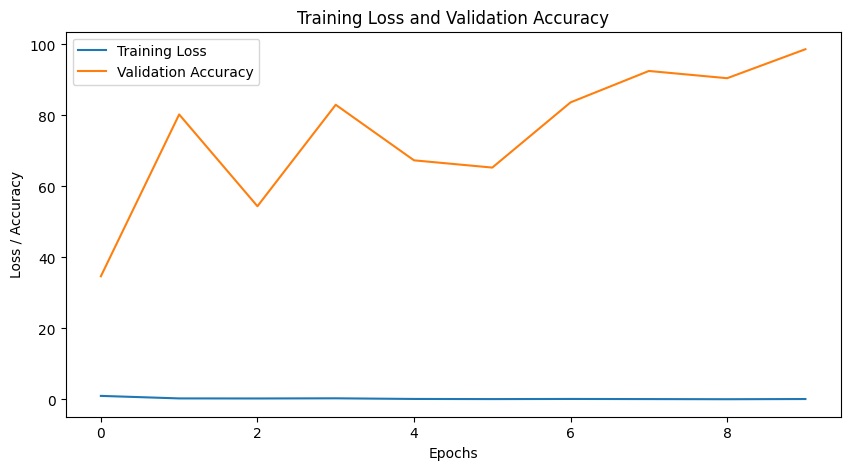

In [7]:
# Plotting training and validation performance
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), train_losses, label='Training Loss')
plt.plot(range(epochs), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.title('Training Loss and Validation Accuracy')
plt.show()

In [41]:
# Testing performance
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 96.60%


In [42]:
torch.save(model.state_dict(), 'seed_classifier.pth')

In [43]:
import cv2
import matplotlib.pyplot as plt

def predict_image(image_path, model, transform, class_names):
    model.eval()
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = Image.fromarray(img)
    img = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img)
        _, pred = torch.max(outputs, 1)
    return class_names[pred.item()]

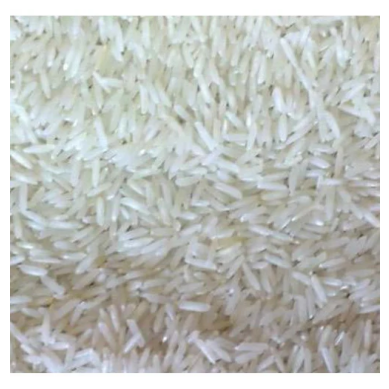

Predicted: HMT Juna Rice


In [60]:
# Example usage:
img_path = '/content/Sample5.webp'

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')
plt.show()

print("Predicted:", predict_image(img_path, model, val_transform, dataset.classes))